# **Imports**

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0
!pip install datasets
!pip install transformers datasets
!pip install autokeras

     |████████████████████████████████| 4.9 MB 4.9 MB/s 
     |████████████████████████████████| 1.8 MB 4.9 MB/s 
     |████████████████████████████████| 237 kB 10.9 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 1.1 MB 37.0 MB/s 
     |████████████████████████████████| 596 kB 56.0 MB/s 
     |████████████████████████████████| 1.2 MB 12.7 MB/s 
     |████████████████████████████████| 92 kB 10.3 MB/s 
     |████████████████████████████████| 352 kB 56.2 MB/s 
     |████████████████████████████████| 48.3 MB 74 kB/s 
     |████████████████████████████████| 99 kB 6.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 4.7 MB/s 
     |████████████████████████████████| 101 kB 13.0 MB/s 
     |████████████████████████████████| 140 kB 76.0 MB/s 
     |████████████████████████████████| 1.1 MB 55.9 MB/s 
     |████████████████████████████████| 

In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import string
import os.path
import matplotlib.pyplot as plt
import ast

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization
import autokeras as ak
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive, auth
# Mount Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
base_dir = './drive/MyDrive/University/00012-NLP/MovieClassification/'
# base_dir = './'

# **Data Collection (Phase 1, Part 1)**

In [ ]:
raw_list = []

In [ ]:
def crawl(mpa):
    for current_page in tqdm(range(1, 9952, 50)):
        response = requests.get('https://www.imdb.com/search/title/?' 
                                + 'title_type=feature,tv_movie,tv_special,documentary,short,tv_short' 
                                + '&certificates=US%3A' + mpa 
                                + '&start=' + str(current_page))

        soup = BeautifulSoup(response.text, 'html.parser')

        for i in range(len(soup.select('h3.lister-item-header a'))):
            title = soup.select('h3.lister-item-header a')[i].get_text()
            plot = soup.select('p.text-muted')[2 * i + 1].get_text()
            raw_list.append([title, mpa, plot])

In [ ]:
crawl('G')

100%|██████████| 200/200 [03:25<00:00,  1.03s/it]


In [ ]:
crawl('PG')

100%|██████████| 200/200 [05:37<00:00,  1.69s/it]


In [ ]:
crawl('PG-13')

100%|██████████| 200/200 [04:42<00:00,  1.41s/it]


In [ ]:
crawl('R')

100%|██████████| 200/200 [04:41<00:00,  1.41s/it]


In [ ]:
raw_data = pd.DataFrame(raw_list, columns = ['Title', 'MPA', 'Plot'])
raw_data.Plot = raw_data.Plot.apply(lambda p: p.replace('\n', ''))
raw_data.head()

,Title,MPA,Plot
0,Toy Story,G,A cowboy doll is profoundly threatened and jea...
1,Cars,G,A hot-shot race-car named Lightning McQueen ge...
2,The Lion King,G,Lion prince Simba and his father are targeted ...
3,Toy Story 4,G,"When a new toy called ""Forky"" joins Woody and ..."
4,The Sound of Music,G,A young novitiate is sent by her convent in 19...


In [ ]:
if not os.path.isdir(base_dir + 'data/'):
    os.mkdir(base_dir + 'data/')

if not os.path.isdir(base_dir + 'data/raw/'):
    os.mkdir(base_dir + 'data/raw/')

raw_data.to_csv(base_dir + 'data/raw/data.csv')

# **Preprocessing (Phase 1, Part 2)**

In [ ]:
df = pd.read_csv(base_dir + 'data/raw/data.csv', index_col=0)
df

,Title,MPA,Plot
0,G,The Lion King,Lion prince Simba and his father are targeted ...
1,G,Cars,A hot-shot race-car named Lightning McQueen ge...
2,G,Ratatouille,A rat who can cook makes an unusual alliance w...
3,G,2001: A Space Odyssey,The Monoliths push humanity to reach for the s...
4,G,The Princess Diaries,Mia Thermopolis has just found out that she is...
...,...,...,...
21595,R,Den of Thieves,An elite unit of the LA County Sheriff's Dept....
21596,R,Blade Runner 2049,Young Blade Runner K's discovery of a long-bur...
21597,R,All the Old Knives,Two CIA agents and ex-lovers (Chris Pine and T...
21598,R,Forgetting Sarah Marshall,Devastated Peter takes a Hawaiian vacation in ...


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df = df.drop(df[df.Plot == 'Add a Plot'].index)
df = df.reset_index().drop(columns = 'index')
df['Plot'] = df['Plot'].str.replace('See full summary', '')

In [ ]:
df['Normalized_Plot'] = df['Plot'].str.lower()
df['Normalized_Plot'] = df['Normalized_Plot'].str.translate(str.maketrans('', '', string.punctuation + '»' + '«'))
df['Normalized_Plot'] = df['Normalized_Plot'].str.translate(str.maketrans('', '', string.digits))
df['Normalized_Plot'] = df['Normalized_Plot'].apply(word_tokenize)
df['Normalized_Plot'] = df['Normalized_Plot'].apply(lambda lst : [word for word in lst if word not in set(stopwords.words('english'))])
df['Normalized_Plot'] = df['Normalized_Plot'].apply(lambda lst : [WordNetLemmatizer().lemmatize(w) for w in lst])

In [ ]:
if not os.path.isdir(base_dir + 'data/'):
    os.mkdir(base_dir + 'data/')

if not os.path.isdir(base_dir + 'data/cleaned/'):
    os.mkdir(base_dir + 'data/cleaned/')

df.to_csv(base_dir + 'data/cleaned/data.csv')

# **Statistics (Phase 1, Part 3)**

In [ ]:
df = pd.read_csv(base_dir + 'data/cleaned/data.csv', index_col=0)
df

,Title,MPA,Plot,Normalized_Plot
0,The Lion King,G,Lion prince Simba and his father are targeted ...,"['lion', 'prince', 'simba', 'father', 'targete..."
1,Cars,G,A hot-shot race-car named Lightning McQueen ge...,"['hotshot', 'racecar', 'named', 'lightning', '..."
2,Luck,G,The curtain is pulled back on the millennia-ol...,"['curtain', 'pulled', 'back', 'millenniaold', ..."
3,2001: A Space Odyssey,G,The Monoliths push humanity to reach for the s...,"['monolith', 'push', 'humanity', 'reach', 'sta..."
4,Ratatouille,G,A rat who can cook makes an unusual alliance w...,"['rat', 'cook', 'make', 'unusual', 'alliance',..."
...,...,...,...,...
27396,Zombie Diaries,R,An unknown virus begins spreading and within w...,"['unknown', 'virus', 'begin', 'spreading', 'wi..."
27397,Gangsta Rap: The Glockumentary,R,The hardest group you've never heard of is bac...,"['hardest', 'group', 'youve', 'never', 'heard'..."
27398,Satan's Sadists,R,"The ""Satans"" are a very cruel biker gang led b...","['satan', 'cruel', 'biker', 'gang', 'led', 'an..."
27399,Train of Life,R,"In 1941, the inhabitants of a small Jewish vil...","['inhabitant', 'small', 'jewish', 'village', '..."


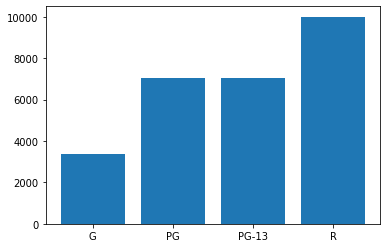

In [ ]:
MPA_counts = {MPA : sum(df['MPA'] == MPA) for MPA in ['G', 'PG', 'PG-13', 'R']}
plt.bar(MPA_counts.keys(), MPA_counts.values())
plt.show()

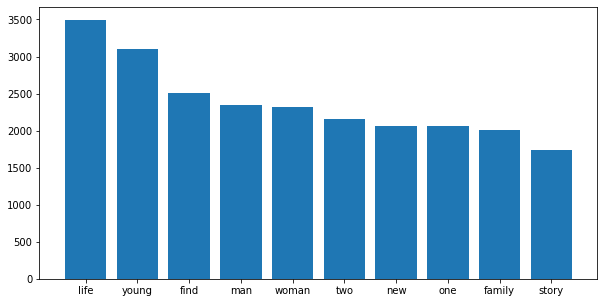

In [ ]:
counter = Counter()
df['Normalized_Plot'].apply(lambda lst : ast.literal_eval(lst)).apply(counter.update)

counter_list = [(k, v) for k, v in sorted(counter.items(), key=lambda item: item[1], reverse=True)]
counter_list = counter_list[:10]
x, y = zip(*counter_list)
plt.figure(figsize=(10, 5), facecolor=None)
plt.bar(x, y)
plt.show()

In [ ]:
print('Sentence count:', df['Plot'].apply(sent_tokenize).apply(len).sum())
print('All words(preprocessed words):', sum(counter.values()))
print('Unique words:', len(counter))

Sentence count: 39317
All words(preprocessed words): 422248
Unique words: 34538


# **Train Preprocessing (Phase 2)**

In [ ]:
df = pd.read_csv(base_dir + 'data/cleaned/data.csv', index_col=0)
df['Normalized_Plot'] = df['Normalized_Plot'].apply(lambda lst : ast.literal_eval(lst))
df

,Title,MPA,Plot,Normalized_Plot
0,The Lion King,G,Lion prince Simba and his father are targeted ...,"[lion, prince, simba, father, targeted, bitter..."
1,Cars,G,A hot-shot race-car named Lightning McQueen ge...,"[hotshot, racecar, named, lightning, mcqueen, ..."
2,Luck,G,The curtain is pulled back on the millennia-ol...,"[curtain, pulled, back, millenniaold, battle, ..."
3,2001: A Space Odyssey,G,The Monoliths push humanity to reach for the s...,"[monolith, push, humanity, reach, star, discov..."
4,Ratatouille,G,A rat who can cook makes an unusual alliance w...,"[rat, cook, make, unusual, alliance, young, ki..."
...,...,...,...,...
27396,Zombie Diaries,R,An unknown virus begins spreading and within w...,"[unknown, virus, begin, spreading, within, wee..."
27397,Gangsta Rap: The Glockumentary,R,The hardest group you've never heard of is bac...,"[hardest, group, youve, never, heard, back, se..."
27398,Satan's Sadists,R,"The ""Satans"" are a very cruel biker gang led b...","[satan, cruel, biker, gang, led, anchor, gang,..."
27399,Train of Life,R,"In 1941, the inhabitants of a small Jewish vil...","[inhabitant, small, jewish, village, central, ..."


In [ ]:
mpa_dict = {'G': 0, 'PG': 1, 'PG-13': 2, 'R': 3}
df['label'] = [mpa_dict[x] for x in df['MPA']]
df['text'] = [' '.join(x) for x in df['Normalized_Plot']]

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['text'], df['label'])

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((20550,), (20550, 4), (6851,), (6851, 4))

# **Simple Text Classification Model (Phase 2, Part 2)**

In [ ]:
max_features = 20000
embedding_dim = 128
sequence_length = 500

In [ ]:
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)
vectorize_layer.adapt(x_train)

In [ ]:
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(text_input)
x = layers.Embedding(max_features + 1, embedding_dim)(x)

x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3)(x)
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(4, activation='sigmoid', name='predictions')(x)

model = tf.keras.Model(text_input, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(tf.constant(x_train), y_train, validation_split=0.2, epochs=3)

Epoch 1/3
514/514 [==============================] - 6s 10ms/step - loss: 1.2706 - accuracy: 0.3876 - val_loss: 1.1760 - val_accuracy: 0.4577
Epoch 2/3
514/514 [==============================] - 5s 10ms/step - loss: 1.0769 - accuracy: 0.5018 - val_loss: 1.1964 - val_accuracy: 0.4421
Epoch 3/3
514/514 [==============================] - 5s 9ms/step - loss: 0.8191 - accuracy: 0.6464 - val_loss: 1.3834 - val_accuracy: 0.4219


In [ ]:
model.save(base_dir + 'models/simple_text_classification', save_format = "tf")
loaded_model = load_model(base_dir + 'models/simple_text_classification')
loaded_model.evaluate(tf.constant(x_test), y_test)

INFO:tensorflow:Assets written to: ./drive/MyDrive/University/00012-NLP/MovieClassification/models/simple_text_classification/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/University/00012-NLP/MovieClassification/models/simple_text_classification/assets


215/215 [==============================] - 1s 6ms/step - loss: 1.3922 - accuracy: 0.4261


[1.392188310623169, 0.4260692000389099]

# **Improved Text Classification Models (Phase 2, Part 3)**

## **Text Classification Using Transformers layer**

In [ ]:
max_features = 20000
embedding_dim = 128
sequence_length = 500

num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(text_input)

embedding_layer = TokenAndPositionEmbedding(sequence_length, max_features, embedding_dim)
x = embedding_layer(x)

transformer_block = TransformerBlock(embedding_dim, num_heads, ff_dim)
x = transformer_block(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)

x = layers.Dense(20, activation='relu')(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=text_input, outputs=outputs)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=3, validation_split=0.2)

Epoch 1/3
514/514 [==============================] - 21s 35ms/step - loss: 1.3396 - accuracy: 0.3584 - val_loss: 1.3073 - val_accuracy: 0.3745
Epoch 2/3
514/514 [==============================] - 17s 33ms/step - loss: 1.2198 - accuracy: 0.4210 - val_loss: 1.1750 - val_accuracy: 0.4545
Epoch 3/3
514/514 [==============================] - 17s 33ms/step - loss: 1.0471 - accuracy: 0.5191 - val_loss: 1.2111 - val_accuracy: 0.4509


In [ ]:
model.save(base_dir + 'models/text_classification_using_transformers', save_format = "tf")
loaded_model = load_model(base_dir + 'models/text_classification_using_transformers')
loaded_model.evaluate(tf.constant(x_test), y_test)

INFO:tensorflow:Assets written to: ./drive/MyDrive/University/00012-NLP/MovieClassification/models/text_classification_using_transformers/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/University/00012-NLP/MovieClassification/models/text_classification_using_transformers/assets


215/215 [==============================] - 3s 13ms/step - loss: 1.2192 - accuracy: 0.4396


[1.2192487716674805, 0.43964385986328125]

## **Text Classification Using Bert**

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-10_H-512_A-8'

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['Hi bitchez!']
text_preprocessed = bert_preprocess_model(text_test)

print(text_test)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, : 20]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, : 20]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, : 20]}')

['Hi bitchez!']
Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 7632 7743 9351  999  102    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.33562768 -0.2538585   0.5599888   0.76626843  0.5676474  -0.60505533
 -0.32637784 -0.9982774   0.2438279   0.9987538  -0.5719133  -0.97347873]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.31094003  0.15382561  1.0201985  ... -0.57107294 -1.365524
   0.05360165]
 [ 0.1665078  -0.37277767 -0.2602708  ...  0.0699846  -1.1501445
  -0.2759685 ]
 [-0.34534103 -0.03975188 -0.9905317  ... -0.21089089 -0.39083523
   0.64529866]
 ...
 [-0.36674708 -0.22294529 -0.02585383 ...  0.08165319 -0.47791135
  -0.05833472]
 [-0.19746575  0.19652915 -0.5719107  ...  0.07476798 -0.18116426
   0.829659  ]
 [ 0.6483316   0.0970015   0.64028853 ... -0.11531498 -0.59721863
  -0.0704602 ]]


In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(4, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))
classifier_model.summary()

tf.Tensor([[0.5097018 0.5128283 0.6508063 0.5713298]], shape=(1, 4), dtype=float32)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
        

In [ ]:
classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
classifier_model.fit(x_train, y_train, validation_split=.3, epochs=3, batch_size=64)

Epoch 1/3
225/225 [==============================] - 244s 1s/step - loss: 1.3752 - accuracy: 0.3383 - val_loss: 1.3305 - val_accuracy: 0.3631
Epoch 2/3
225/225 [==============================] - 230s 1s/step - loss: 1.3362 - accuracy: 0.3491 - val_loss: 1.3383 - val_accuracy: 0.3631
Epoch 3/3
225/225 [==============================] - 230s 1s/step - loss: 1.3393 - accuracy: 0.3466 - val_loss: 1.3344 - val_accuracy: 0.3631


In [ ]:
classifier_model.save(base_dir + 'models/text_classification_using_bert', save_format = "tf")
loaded_model = load_model(base_dir + 'models/text_classification_using_bert')
loaded_model.evaluate(tf.constant(x_test), y_test)

INFO:tensorflow:Assets written to: ./drive/MyDrive/University/00012-NLP/MovieClassification/models/text_classification_using_bert/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/University/00012-NLP/MovieClassification/models/text_classification_using_bert/assets


215/215 [==============================] - 23s 104ms/step - loss: 1.3246 - accuracy: 0.1244


[1.3245573043823242, 0.12436141073703766]

## **Find The Best Performing Model**

In [ ]:
X_train = np.array(x_train)
X_test = np.array(x_test)

In [ ]:
clf = ak.TextClassifier(max_trials=3)

clf.fit(X_train, y_train, validation_split=0.3, epochs=3)

Trial 3 Complete [00h 09m 41s]
val_loss: 1.119246006011963

Best val_loss So Far: 1.119246006011963
Total elapsed time: 00h 10m 44s
INFO:tensorflow:Oracle triggered exit
Epoch 1/3
643/643 [==============================] - 196s 282ms/step - loss: 1.1939 - accuracy: 0.4400
Epoch 2/3
643/643 [==============================] - 181s 282ms/step - loss: 1.0403 - accuracy: 0.5322
Epoch 3/3
643/643 [==============================] - 181s 281ms/step - loss: 0.9214 - accuracy: 0.6026


INFO:tensorflow:Assets written to: ./text_classifier/best_model/assets


INFO:tensorflow:Assets written to: ./text_classifier/best_model/assets


In [ ]:
model = clf.export_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 expand_last_dim (ExpandLastDim  (None, 1)           0           ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 bert_tokenizer (BertTokenizer)  ((None, None),      0           ['expand_last_dim[0][0]']        
                                 (None, None),                                                    
                                 (None, None))                                                

In [ ]:
model.save(base_dir + "models/clf_best_performing", save_format = "tf")
loaded_model = load_model(base_dir + "models/clf_best_performing", custom_objects = ak.CUSTOM_OBJECTS)
loaded_model.evaluate(X_test, y_test)

INFO:tensorflow:Assets written to: ./drive/MyDrive/University/00012-NLP/MovieClassification/models/clf_best_performing/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/University/00012-NLP/MovieClassification/models/clf_best_performing/assets


215/215 [==============================] - 23s 99ms/step - loss: 1.1519 - accuracy: 0.4998


[1.1518988609313965, 0.4997810423374176]